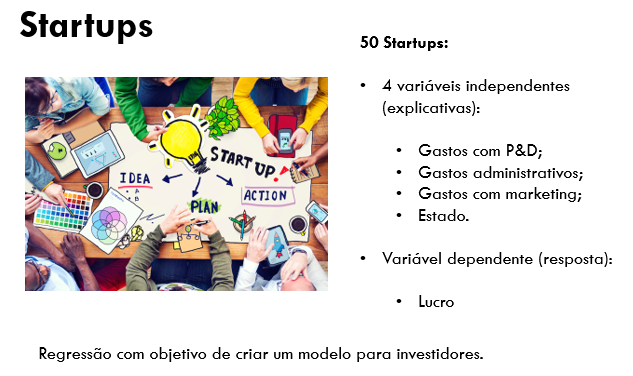


In [1]:
# mape incluído na versão 0.24 (quando colab atualizar, não preisaremos mais desta célula)
#!pip install -U scikit-learn

## Carregar base de Dados

In [14]:
# Importação dos pacotes
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression

# Seed para reprodução de resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

In [15]:
data = pd.read_csv('50_Startups.csv', index_col=0)
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
ID,,,,,
1,165349.20,136897.80,471784.10,New York,192261.83
2,162597.70,151377.59,443898.53,California,191792.06
3,153441.51,101145.55,407934.54,Florida,191050.39
4,144372.41,118671.85,383199.62,New York,182901.99
5,142107.34,91391.77,366168.42,Florida,166187.94


In [16]:
data.shape

(50, 5)

In [17]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


## Dummy Coding

In [18]:
data = pd.get_dummies(data, columns=['State'], drop_first=True)
data.head()

,R&D Spend,Administration,Marketing Spend,Profit,State_Florida,State_New York
ID,,,,,,
1,165349.20,136897.80,471784.10,192261.83,0,1
2,162597.70,151377.59,443898.53,191792.06,0,0
3,153441.51,101145.55,407934.54,191050.39,1,0
4,144372.41,118671.85,383199.62,182901.99,0,1
5,142107.34,91391.77,366168.42,166187.94,1,0


## One Hot Encoding

In [116]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop='first')
new_data = enc.fit_transform(np.array(data['State']).reshape(-1,1)).toarray()
df_new_data = pd.DataFrame(new_data, columns = ['State_Florida', 'State_New York'])
pd.concat([data.reset_index(), df_new_data], axis = 1).drop(columns='State').set_index('ID').head()

,R&D Spend,Administration,Marketing Spend,Profit,State_Florida,State_New York
ID,,,,,,
1,165349.20,136897.80,471784.10,192261.83,0.0,1.0
2,162597.70,151377.59,443898.53,191792.06,0.0,0.0
3,153441.51,101145.55,407934.54,191050.39,1.0,0.0
4,144372.41,118671.85,383199.62,182901.99,0.0,1.0
5,142107.34,91391.77,366168.42,166187.94,1.0,0.0


## Separar base em treino e teste

In [19]:
from sklearn.model_selection import train_test_split 
# Agora usaremos a função para fazer de fato a separação. 
# Já faremos a separação em treino e teste e entrada e saída.
X = data.loc[:,data.columns != 'Profit']  # Entrada
y = data.Profit    # Saída
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
# Vamos olhar os shapes da bases de treino e teste
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40, 5)
(10, 5)
(40,)
(10,)


## Normalização

In [9]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

## Machine Learning

In [21]:
# treinar modelo
from sklearn.tree import DecisionTreeRegressor

def train_and_predict(X_train, y_train, X_test):
  model = DecisionTreeRegressor()  # criação do modelo
  model.fit(X_train, y_train);     # treinamento
  y_pred = model.predict(X_test)   # inferência do teste
  return model, y_pred

model, y_pred = train_and_predict(X_train, y_train, X_test)

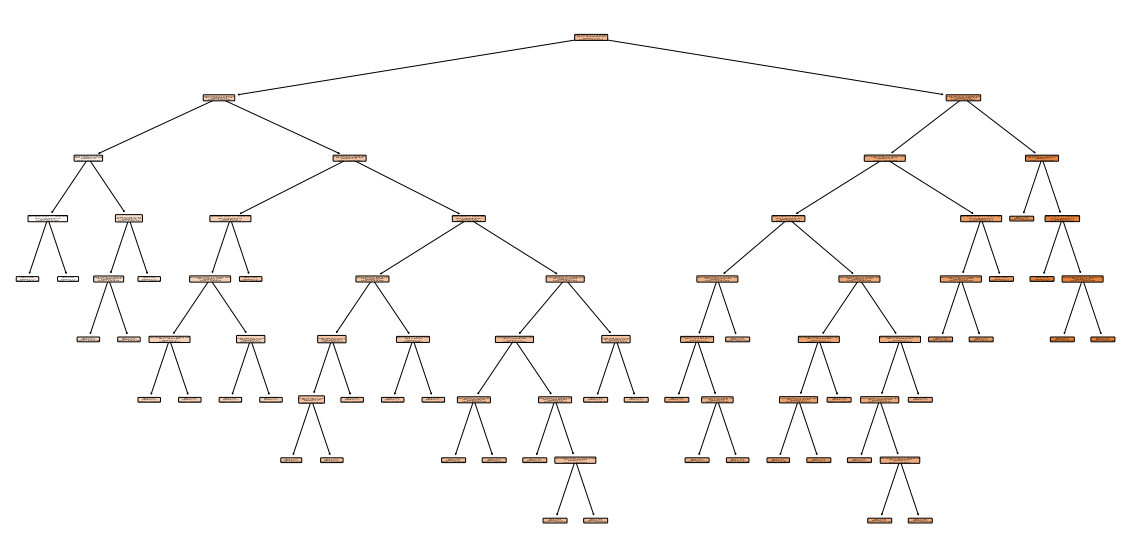

In [22]:
# Visualização gráfica da árvore de decisão
from sklearn.tree import plot_tree
plt.subplots(figsize=(20, 10)) # Definir tamanho da imagem a ser gerada
plot_tree(model, filled=True, rounded=True, feature_names=X_train.columns); # plota a árvore

In [23]:
model.get_depth()

8

### Avaliar modelo treinado na base de teste e treino

In [41]:
def evaluate(y_test, y_pred, X_test):  

  # MAPE
  from sklearn.metrics import mean_absolute_percentage_error
  mape = mean_absolute_percentage_error(y_test, y_pred)
  print('MAPE: ', mape)

  # R2
  from sklearn.metrics import r2_score
  r2 = r2_score(y_test, y_pred)
  print('R2: ', r2)

  n = len(y_test)
  p = X_test.shape[1]
  adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
  print('R2 ajustado: ', adj_r2)

print('Teste')
evaluate(y_test, y_pred, X_test)

print('\nTreino')
y_train_pred = model.predict(X_train)
evaluate(y_train, y_train_pred, X_train)

Teste
MAPE:  0.08197026577674957
R2:  0.9564219119563651
R2 ajustado:  0.9019493019018214

Treino
MAPE:  0.0
R2:  1.0
R2 ajustado:  1.0


In [42]:
from sklearn.model_selection import GridSearchCV
 
tuned_parameters = [{'max_depth': [4,5,6,7,8,9,10,11,12,14,15,16,17,18],
                     'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}]

model = GridSearchCV(DecisionTreeRegressor(), tuned_parameters, scoring='r2')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Teste')
evaluate(y_test, y_pred, X_test)

print('\nTreino')
y_train_pred = model.predict(X_train)
evaluate(y_train, y_train_pred, X_train)

Teste
MAPE:  0.1026476721745887
R2:  0.95282917645674
R2 ajustado:  0.8938656470276651

Treino
MAPE:  0.051235303568573407
R2:  0.9848338437226106
R2 ajustado:  0.9826035266229945


In [44]:
model.best_params_

{'max_depth': 8, 'min_samples_leaf': 2}

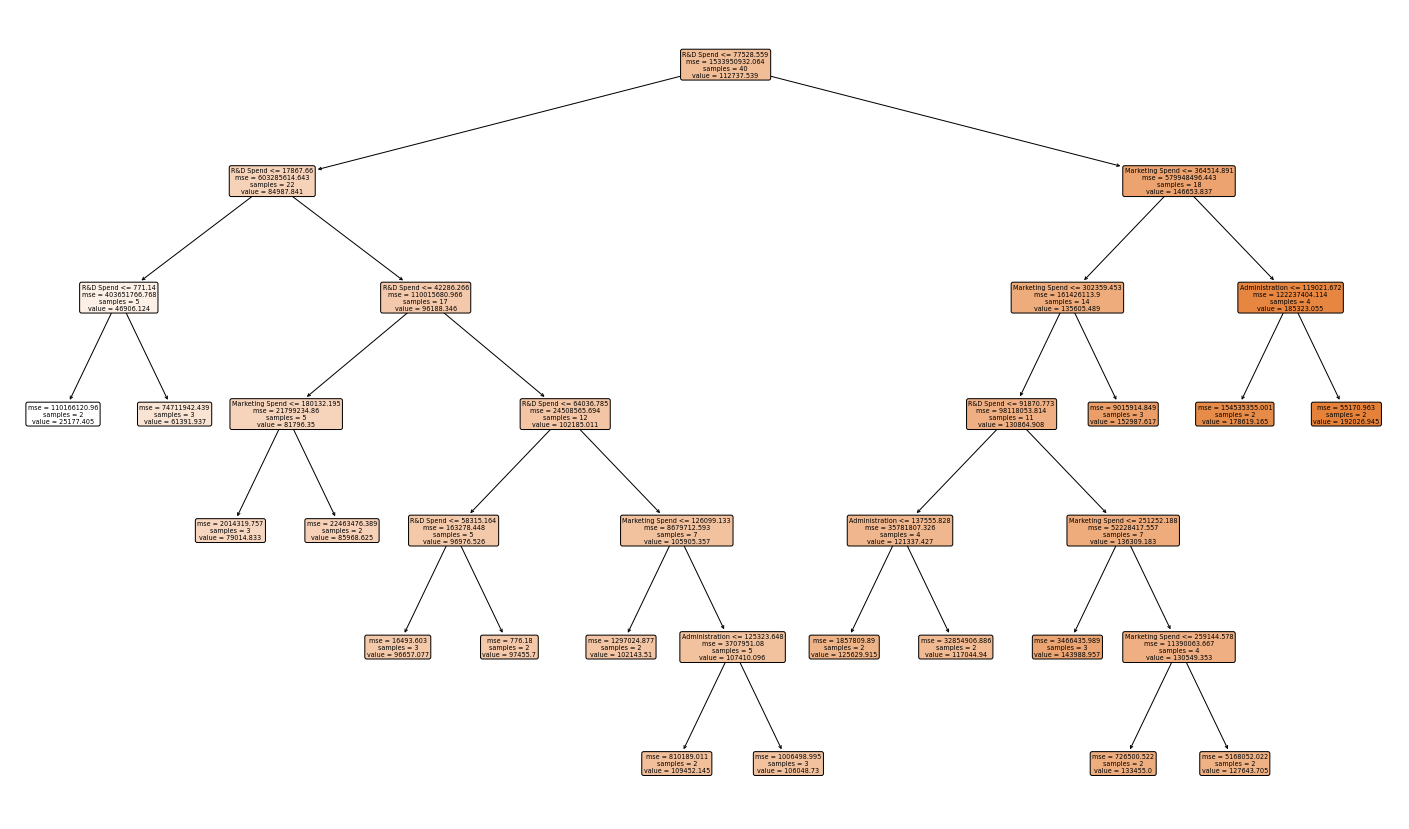

In [45]:
# Visualização gráfica da árvore de decisão
plt.subplots(figsize=(25, 15)) # Definir tamanho da imagem a ser gerada
plot_tree(model.best_estimator_, filled=True, rounded=True, feature_names=X_train.columns); # plota a árvore

In [43]:
# Se p_value > 0.05, o atributo pode não ser uma boa adição pro modelo
_, pval = f_regression(X_train, y_train)
print(pval)

[3.34000140e-24 1.94612100e-01 3.58901311e-08 5.56073942e-01
 6.72914598e-01]


## Backward Elimination

### Retirar State

In [32]:
X_train_1 = X_train.iloc[:, 0:3]
X_test_1 = X_test.iloc[:, 0:3]

In [56]:
model

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15,
                                        16, 17, 18],
                          'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}],
             scoring='r2')

In [47]:
# Testar novamente com o modelo do grid search

model.fit(X_train_1, y_train)
y_pred_1 = model.predict(X_test_1)
print('Teste')
evaluate(y_test, y_pred_1, X_test_1)

print('\nTreino')
y_train_pred_1 = model.predict(X_train_1)
evaluate(y_train, y_train_pred_1, X_train_1)

Teste
MAPE:  0.1477250627584638
R2:  0.8997007022580459
R2 ajustado:  0.8495510533870688

Treino
MAPE:  0.0
R2:  1.0
R2 ajustado:  1.0


In [48]:
_, pval = f_regression(X_train_1, y_train)
pval

array([3.34000140e-24, 1.94612100e-01, 3.58901311e-08])

### Retirar ADM

In [49]:
X_train_2 = X_train.iloc[:, [0,2]]
X_test_2 = X_test.iloc[:, [0,2]]

In [50]:
# Gerar modelo e testar novamente
#model_2, y_pred_2 = train_and_predict(X_train_2, y_train, X_test_2)
#evaluate(y_test, y_pred_2, X_test_2)

model.fit(X_train_2, y_train)
y_pred_2 = model.predict(X_test_2)
print('Teste')
evaluate(y_test, y_pred_2, X_test_2)

print('\nTreino')
y_train_pred_2 = model.predict(X_train_2)
evaluate(y_train, y_train_pred_2, X_train_2)

Teste
MAPE:  0.0817109080997334
R2:  0.9565928643166635
R2 ajustado:  0.9441908255499959

Treino
MAPE:  0.0
R2:  1.0
R2 ajustado:  1.0


In [51]:
_, pval = f_regression(X_train_2, y_train)
pval

array([3.34000140e-24, 3.58901311e-08])

### Retirar Marketing

In [52]:
X_train_3 = X_train.iloc[:,0:1]  # coloca em um dataframe para manter duas dimensões e não dar erro no treinamento
X_test_3 = X_test.iloc[:,0:1]

In [53]:
# Gerar modelo e testar novamente
#model_3, y_pred_3 = train_and_predict(X_train_3, y_train, X_test_3)
#evaluate(y_test, y_pred_3, X_test_3)

model.fit(X_train_3, y_train)
y_pred_3 = model.predict(X_test_3)
print('Teste')
evaluate(y_test, y_pred_3, X_test_3)

print('\nTreino')
y_train_pred_3 = model.predict(X_train_3)
evaluate(y_train, y_train_pred_3, X_train_3)

Teste
MAPE:  0.13314352279156758
R2:  0.9144456085354263
R2 ajustado:  0.9037513096023546

Treino
MAPE:  0.030069467264336548
R2:  0.9872197205041539
R2 ajustado:  0.9868833973595263


In [54]:
_, pval = f_regression(X_train_3, y_train)
pval

array([3.3400014e-24])

## Modelo com maior R2 ajustado: model_2

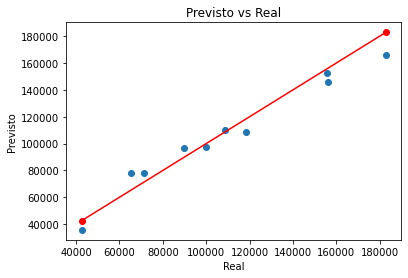

In [55]:
#previsto vs. real
plt.scatter(x=y_test, y=y_pred_2)
plt.title('Previsto vs Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [min(y_test), max(y_test)]
plt.plot(x, x, 'ro-'); #reta onde y=x